In [36]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [37]:
df = pd.read_excel("../../raw_data/market_data.xlsx").loc[5:106].reset_index(drop = True)
df["Time (UTC+10)"] = pd.to_datetime(df["Time (UTC+10)"])
vicp = df["Regions VIC Trading Price ($/MWh)"]
vicd = df["Regions VIC Operational Demand (MW)"]
time = df["Time (UTC+10)"]

In [38]:
price = pd.DataFrame()
price["time"] = time
price["price"] = vicp

demand = pd.DataFrame()
demand["time"] = time
demand["demand"] = vicd

In [39]:
price

,time,price
0,2018-01-01 02:30:00,67.43
1,2018-01-01 03:00:00,66.31
2,2018-01-01 03:30:00,67.72
3,2018-01-01 04:00:00,65.50
4,2018-01-01 04:30:00,64.50
...,...,...
97,2018-01-03 03:00:00,49.37
98,2018-01-03 03:30:00,50.99
99,2018-01-03 04:00:00,52.00
100,2018-01-03 04:30:00,54.33


In [40]:
vicp

0      67.43
1      66.31
2      67.72
3      65.50
4      64.50
       ...  
97     49.37
98     50.99
99     52.00
100    54.33
101    55.38
Name: Regions VIC Trading Price ($/MWh), Length: 102, dtype: float64

In [56]:
def CMA(df, col, n):
    MA = []
    dfc = df.reset_index(drop = True)
    print(dfc)
    for i in dfc.index:
        if (i > n - 1) and i < len(df) - n:
            Period = []
            for j in range(1, n + 1):
                Period.append(df[col].loc[i - j])
                Period.append(df[col].loc[i + j])
            entry = np.mean(Period)
        else:
            entry = np.nan

        MA.append(entry)
        
    dfn = pd.DataFrame()
    dfn["MA"] = MA
    
    dff = pd.merge(dfc, dfn, left_index = True, right_index = True, how = "inner")
    return dff.dropna().reset_index(drop = True)

In [57]:
PriceMA = CMA(price, "price", 5)
PriceMA.columns = ["Time", "Price", "MA"]

                   time  price
0   2018-01-01 02:30:00  67.43
1   2018-01-01 03:00:00  66.31
2   2018-01-01 03:30:00  67.72
3   2018-01-01 04:00:00  65.50
4   2018-01-01 04:30:00  64.50
..                  ...    ...
97  2018-01-03 03:00:00  49.37
98  2018-01-03 03:30:00  50.99
99  2018-01-03 04:00:00  52.00
100 2018-01-03 04:30:00  54.33
101 2018-01-03 05:00:00  55.38

[102 rows x 2 columns]


<AxesSubplot:ylabel='Price'>

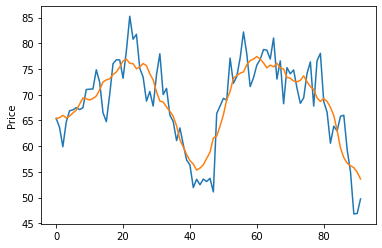

In [58]:
sns.lineplot(y = PriceMA["Price"], x = PriceMA.index)
sns.lineplot(y = PriceMA["MA"], x = PriceMA.index)

In [44]:
UpperPrice = PriceMA[PriceMA.Price >= PriceMA.MA]
LowerPrice = PriceMA[PriceMA.Price < PriceMA.MA]

In [45]:
DemandMA = CMA(demand, "demand", 5)
DemandMA.columns = ["Time", "Demand", "MA"]

                   time  demand
0   2018-01-01 02:30:00    3833
1   2018-01-01 03:00:00    3749
2   2018-01-01 03:30:00    3702
3   2018-01-01 04:00:00    3688
4   2018-01-01 04:30:00    3700
..                  ...     ...
97  2018-01-03 03:00:00    3884
98  2018-01-03 03:30:00    3879
99  2018-01-03 04:00:00    3930
100 2018-01-03 04:30:00    3995
101 2018-01-03 05:00:00    4088

[102 rows x 2 columns]


<AxesSubplot:ylabel='Demand'>

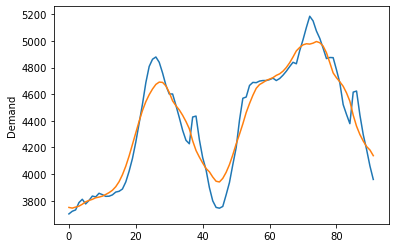

In [46]:
sns.lineplot(y = DemandMA["Demand"], x = DemandMA.index)
sns.lineplot(y = DemandMA["MA"], x = DemandMA.index)

In [47]:
UpperDemand = DemandMA[DemandMA.Demand >= DemandMA.MA]
LowerDemand = DemandMA[DemandMA.Demand < DemandMA.MA]

In [48]:
def intersect(price, demand, status):
    inter = pd.merge(price, demand, on = "Time", how = "inner")
    inter["Status"] = status
    return inter.drop(["MA_x", "MA_y"], axis = 1)

In [49]:
Charge = intersect(LowerPrice, LowerDemand, "Charge")
Discharge = intersect(UpperPrice, UpperDemand, "Discharge")

In [50]:
def BiggerPicture(df, Charge, Discharge):
    cdc = pd.concat([Charge, Discharge], ignore_index = True)

    cdc = cdc[["Time", "Status"]]
    dff = pd.merge(df, cdc, left_on = "Time (UTC+10)", right_on = "Time", how = "left")
    
    return dff[["Time (UTC+10)", "Status"]].replace(np.nan, "Do Nothing")

In [51]:
df = BiggerPicture(df, Charge, Discharge).head(50)
df

,Time (UTC+10),Status
0,2018-01-01 02:30:00,Do Nothing
1,2018-01-01 03:00:00,Do Nothing
2,2018-01-01 03:30:00,Do Nothing
3,2018-01-01 04:00:00,Do Nothing
4,2018-01-01 04:30:00,Do Nothing
5,2018-01-01 05:00:00,Do Nothing
6,2018-01-01 05:30:00,Charge
7,2018-01-01 06:00:00,Charge
8,2018-01-01 06:30:00,Do Nothing
9,2018-01-01 07:00:00,Discharge


In [55]:
dff = pd.merge(df, price, left_on = "Time (UTC+10)", right_on = "time", how = "left").drop('time', axis = 1)
dff

,Time (UTC+10),Status,price
0,2018-01-01 02:30:00,Do Nothing,67.43
1,2018-01-01 03:00:00,Do Nothing,66.31
2,2018-01-01 03:30:00,Do Nothing,67.72
3,2018-01-01 04:00:00,Do Nothing,65.50
4,2018-01-01 04:30:00,Do Nothing,64.50
5,2018-01-01 05:00:00,Do Nothing,65.41
6,2018-01-01 05:30:00,Charge,63.66
7,2018-01-01 06:00:00,Charge,59.90
8,2018-01-01 06:30:00,Do Nothing,64.67
9,2018-01-01 07:00:00,Discharge,66.89


In [ ]:
# calculate revenue

# calculate market revenue -> need market dispatch
dff = 